1-IMPORT AND INSTALL DEPEDENCES 

In [1]:
!pip install tensorflow==2.16.1 scikit-learn matplotlib mediapipe opencv-python imutils

In [1]:
import cv2
import numpy as np 
import os
from matplotlib import pyplot as plt
import time 
import mediapipe as mp
import requests
import imutils 
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import TensorBoard

2-KEYPOINTS USING MEDIAPIPE HOLISTIC 

In [5]:
mp_holistic = mp.solutions.holistic
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
#face_connections = mp_face_mesh.FACE_CONNECTIONS

In [24]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False 
    results = model.process(image)
    image.flags.writeable = True 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results 

In [26]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks,  mp_face_mesh.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    
    
    

In [28]:
 def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,200,40), circle_radius=1 ,thickness= 1),
                             mp_drawing.DrawingSpec(color=(40,100,90), circle_radius=1 ,thickness= 1)
                             )
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                          mp_drawing.DrawingSpec(color=(230,20,100), circle_radius=1 ,thickness= 2)
                          )
     
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(70,140,256), circle_radius=1 ,thickness= 2)
                             )
     
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(190,30,188), circle_radius=1 ,thickness= 2)
                             )
     

In [3]:
def positional_encoding(sequence_length, d_model):
    position = np.arange(sequence_length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
    pe = np.zeros((sequence_length, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return tf.convert_to_tensor(pe, dtype=tf.float32)

In [15]:
def transformer_encoder_layer(input_layer, d_model, num_heads, dff, rate=0.1):
    # Multi-head attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(input_layer, input_layer)
    attn_output = Dropout(rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(input_layer + attn_output)


    ffn_output = Dense(dff, activation='relu')(out1)
    ffn_output = Dense(d_model)(ffn_output)
    ffn_output = Dropout(rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    return out2

In [17]:
def create_transformer_model(sequence_length, d_model, num_heads, dff, num_layers, num_classes):
    inputs = Input(shape=(sequence_length, d_model))

    # Add positional encoding
    pos_encoding = positional_encoding(sequence_length, d_model)
    x = inputs + pos_encoding

    # Add transformer encoder layers
    for _ in range(num_layers):
        x = transformer_encoder_layer(x, d_model, num_heads, dff)

    # Global Average Pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Fully connected layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Build and compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [30]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)as holistic:
   # a = 0 
    while(cap.isOpened()): #and( a<30):
        ret, frame = cap.read()
       
        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)
        print(results)
        cv2.imshow('opencvFeed', image)
      #  a = a+1 
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
        

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

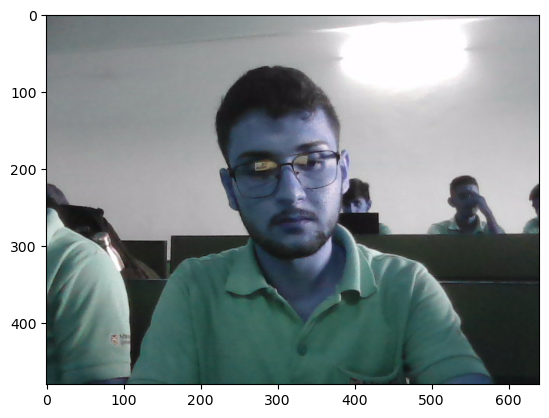

In [32]:
plt.imshow(frame)

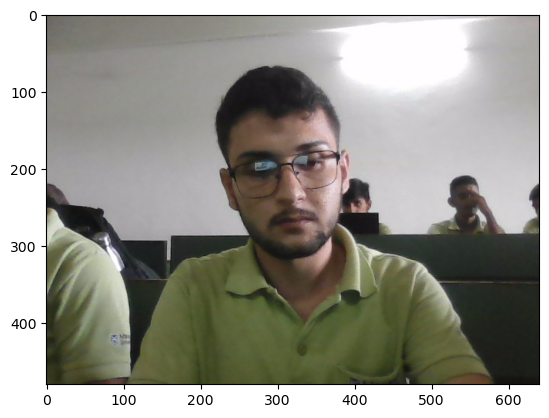

In [34]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [36]:
draw_landmarks(frame, results)

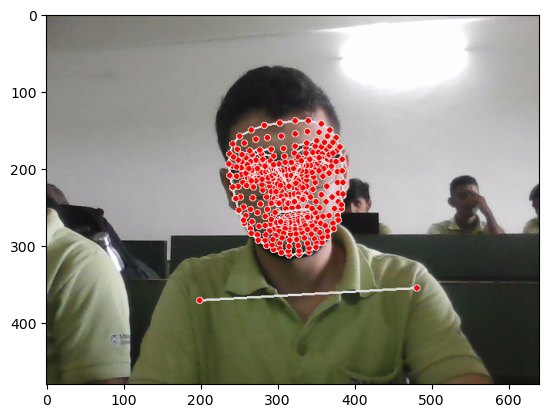

In [38]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

3-EXTRACT KEYPOINT VALUES 

In [41]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x,res.y,res.z,res.visibility])
    pose.append(test)

In [43]:
pose = np.array([[res.x,res.y,res.z,res.visibility]for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face= np.array([[res.x,res.y,res.z,]for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh= np.array([[res.x,res.y,res.z,]for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh= np.array([[res.x,res.y,res.z,]for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [45]:
def extract_keypoints(results):
    pose = np.array([[res.x,res.y,res.z,res.visibility]for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
    face= np.array([[res.x,res.y,res.z,]for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh= np.array([[res.x,res.y,res.z,]for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh= np.array([[res.x,res.y,res.z,]for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

4-SETUP FOLDERS FOR COLLECTION 

In [21]:
DATA_PATH =os.path.join('MP_Data')
actions = np.array(['fine','finish','forget','go','hello'])
no_sequences = 30 
sequence_length = 30 

In [31]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH345, action, str(sequence)))
        except:
            pass
                    
        

In [57]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)as holistic:
    #a = 1
    #n = sequence
    for action in actions:
        for sequence in range(no_sequences):
     #       if a == 1 or cv2.waitKey(10) & 0xFF == ord('w'):
     #          sequence = n
     #          a = 1 
                for frame_num in range(sequence_length):
                     
                        ret, frame = cap.read()
                        image, results = mediapipe_detection(frame, holistic)
                        draw_styled_landmarks(image, results)
                        print(results)
        
                        if frame_num == 0:
                           cv2.putText(image, 'STARTING COLLECTION', (120,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,100,100),4 ,cv2.LINE_AA)
                           cv2.putText(image, 'collecting frame for {} video number {}'.format(action, sequence), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,100),1 ,cv2.LINE_AA)
                           cv2.waitKey(3000)
                        else:
                           cv2.putText(image, 'collecting frame for {} video number {}'.format(action, sequence), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,100),1 ,cv2.LINE_AA)
                     
                        cv2.imshow('opencvFeed', image)
                      # a = a+1 
        
                        keypoints = extract_keypoints(results)
                        npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                        np.save(npy_path, keypoints)
                        if cv2.waitKey(10) & 0xFF == ord('q'):
                             input("press enter ti continue")
                            
        #                    a = 0 
         #                   n = sequence
          #                  print(n)
           #                 break
                         
cap.release()
cv2.destroyAllWindows()

C:\Users\hamed\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

KeyboardInterrupt: Interrupted by user

In [93]:
cap.release()

cv2.destroyAllWindows()

In [47]:
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical

In [23]:
d_model = 1662  # Number of features (keypoints size per frame)
sequence_length = 30  # Number of frames
num_heads = 8  # Number of attention heads
dff = 2048  # Feed-forward network hidden layer size
num_layers = 4  # Number of transformer encoder layers
num_classes = len(actions)  # Number of actions to classify

In [37]:
label_map = {label:num for num, label in enumerate(actions)}

In [39]:
label_map


{'fine': 0, 'finish': 1, 'forget': 2, 'go': 3, 'hello': 4}

In [41]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [107]:
label_map

{'fine': 0, 'finish': 1, 'forget': 2, 'go': 3, 'hello': 4}

In [109]:
np.array(sequences).shape


(150, 30, 1662)

In [111]:
np.array(labels).shape

(150,)

In [113]:
x = np.array(sequences)

In [115]:
x.shape

(150, 30, 1662)

In [45]:
y = to_categorical(labels).astype(int)

NameError: name 'to_categorical' is not defined

In [119]:
y

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0,

In [121]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05)

In [123]:
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense
#from tensorflow.keras.callbacks import TensorBoard

In [125]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [127]:
'''model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))'''

In [129]:
#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [81]:
#model.fit(x_train, y_train, epochs=1000, callbacks=[tb_callback])

NameError: name 'x_train' is not defined

In [25]:
transformer_model = create_transformer_model(sequence_length, d_model, num_heads, dff, num_layers, num_classes)

In [27]:
transformer_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 1662)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 1662)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1662)  │ 88,433,358 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 1662)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 1662)  │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 1662)  │      3,324 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 2048)  │  3,405,824 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30, 1662)  │  3,405,438 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 1662)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 30, 1662)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1662)  │      3,324 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1662)  │ 88,433,358 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 30, 1662)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 30, 1662)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1662)  │      3,324 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 30, 2048)  │  3,405,824 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 30, 1662)  │  3,405,438 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 30, 1662)  │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 30, 1662)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1662)  │      3,324 │ add_4[0][0]     

 Total params: 381,113,749 (1.42 GB)

 Trainable params: 381,113,749 (1.42 GB)

 Non-trainable params: 0 (0.00 B)

In [49]:
x = np.array(sequences)
y = to_categorical(labels).astype(int)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05)

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
transformer_model.fit(x_train, y_train, epochs=10, callbacks=[tb_callback])

In [72]:

res = model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step


In [74]:
actions[np.argmax(res[4])]

'hello'

In [76]:
actions[np.argmax(y_test[4])]

'go'

In [78]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 596,741 (2.28 MB)

 Trainable params: 596,741 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
res = model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [273]:
model.save('action1.h5')

In [163]:
model.load_weights('action1.h5')

In [141]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [143]:
yhat = model.predict(x_train)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step


In [145]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [147]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[114,   1],
        [  0,  27]],

       [[113,   0],
        [  1,  28]],

       [[112,   1],
        [  0,  29]],

       [[113,   1],
        [  1,  27]],

       [[113,   0],
        [  1,  28]]], dtype=int64)

In [149]:
accuracy_score(ytrue, yhat)

0.9788732394366197

In [151]:
colors = [(245,117,16), (117,245,16), (16,117,245),(16,117,245),(16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [153]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

IndexError: list index out of range

<Figure size 1800x1800 with 0 Axes>

In [169]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.1

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (30,) + inhomogeneous part.

In [100]:
np.expand_dims(x_test[0], axis= 0).shape

(1, 30, 1662)

In [177]:
model.predict(np.expand_dims(x_test[0], axis= 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


array([[5.7069031e-03, 3.8417659e-07, 9.9418700e-01, 9.5001240e-05,
        1.0717821e-05]], dtype=float32)

In [157]:
cap.release()
cv2.destroyAllWindows()